<a href="https://colab.research.google.com/github/jesusvillota/Data_Science_Course/blob/main/2_2_Forecasting_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load the Penn World Tables data
file_path = '/content/drive/My Drive/conflict_data_competition.dta'  # Use your file path here
df = pd.read_stata(file_path)

# Display basic information about the dataset
df.head()

,id,period,fatalities_ucdp,anyviolence,stock_tokens,stock_topic_0,stock_topic_1,stock_topic_10,stock_topic_11,stock_topic_12,...,stock_topic_14,stock_topic_2,stock_topic_3,stock_topic_4,stock_topic_5,stock_topic_6,stock_topic_7,stock_topic_8,stock_topic_9,tokens
0,1.0,201001,0,0,2575.381592,0.023232,0.059388,0.141243,0.038883,0.111064,...,0.138674,0.033728,0.082712,0.006965,0.030902,0.078225,0.150403,0.036590,0.009944,580
1,1.0,201002,0,0,2197.305176,0.022941,0.060683,0.137253,0.039457,0.111399,...,0.145247,0.032783,0.083496,0.007688,0.030133,0.079193,0.142888,0.035466,0.012196,137
2,1.0,201003,0,0,1951.844238,0.033467,0.081884,0.130767,0.039558,0.103586,...,0.136288,0.030941,0.076614,0.008340,0.037367,0.072738,0.130102,0.033357,0.012400,194
3,1.0,201004,0,0,2310.475342,0.025304,0.075646,0.099589,0.028937,0.106169,...,0.189444,0.024278,0.073738,0.008701,0.039523,0.086513,0.104838,0.031440,0.013734,749
4,1.0,201005,0,0,2217.380371,0.025450,0.068918,0.106555,0.033682,0.108386,...,0.180092,0.021649,0.070195,0.008664,0.059526,0.084854,0.106971,0.029204,0.012859,369


# Competition

Predict for each country id:

1.   the logged number of battle deaths + 1 (log(fatalities_ucdp+1))
2.   the likelihood of at least one battle death (anyviolence)


Only use the information available in the dataset. However, you can use feature engineering to create predictors using the information in the dataset. Therefore, there are two ways improving predictions



1.   Feature engineering
2.   Prediction algorithms



The goal of the competition is to have the best ROC-AUC and R-squared in:

1.   the pseudo out-of-sample expanding window
2.   for the "true" out-of-sample July 2024 prediction

In order to participate in the competition, upload to the moodle your predictions as a CSV file with country id and two predictions for the "true" out-of-sample July 2024 prediction with the following variable names:



1.   pred_log_fatalities
2.   pred_anyviolence









----
----

# Forecasting Conflict Fatalities with an Expanding Window OLS Model

This code performs an out-of-sample forecasting analysis using an expanding window approach with Ordinary Least Squares (OLS) regression. The goal is to predict the log-transformed number of conflict fatalities in the next period for each country, based on historical data from the Penn World Tables and other predictors. Let's break down the key steps and concepts involved in this analysis.

## 1. **Loading and Preparing the Data**

The dataset is loaded from a `.dta` file, which is a common format used in econometrics and statistics. After loading the data into a DataFrame (`df`), the code computes the log-transformed number of conflict fatalities, `log_fatalities`, using the formula:

$$
\text{log_fatalities} = \log(\text{fatalities_ucdp} + 1)
$$

Adding 1 before taking the logarithm ensures that zero values (no fatalities) are handled appropriately without causing mathematical errors (since $\log(0)$ is undefined). This transformation is useful because it reduces skewness in the data, making it more suitable for linear regression.

## 2. **Data Sorting and Lag Creation**

The data is sorted by `id` (country identifier) and `period` (time, formatted as YYYYMM). Sorting ensures that data is properly aligned for time series analysis.

A new column, `log_fatalities_next`, is created by shifting the `log_fatalities` values by one period within each country. This lagging operation allows the model to use current period data to predict the next period’s fatalities:

$$
\text{log_fatalities_next}_{t} = \text{log_fatalities}_{t+1}
$$

Rows with missing values in `log_fatalities_next` (which occur for the last period in each country) are dropped, as they do not have a subsequent period to predict.

## 3. **Expanding Window OLS Regression**

The code implements an expanding window strategy for OLS regression. This approach involves using all available data up to a certain point (the current period) to train the model and then testing the model on the next period. This method is ideal for time series data, where the model benefits from increasing amounts of training data over time.

### Steps in the Expanding Window OLS:

1. **Loop Through Periods**: The code iterates over each unique period in the dataset. For each period, it performs the following steps:
   
2. **Filter Training and Testing Sets**:
   - **Training Set**: All data up to, but not including, the current period.
   - **Test Set**: Data for the current period only. This simulates a real-world scenario where we train the model on past data and predict future events.

3. **Add Intercept**: A constant (intercept term) is added to both the training and test datasets. This is important for the OLS model to learn a baseline level of fatalities that does not depend on the predictors.

4. **Fit OLS Model**: The OLS model is fitted to the training data using the predictors `stock_tokens` and `log_fatalities`. The fitted model estimates coefficients that minimize the sum of squared errors between the observed and predicted `log_fatalities_next`.

### Mathematical Formulation of OLS:

The OLS regression model in this context can be formulated as:

$$
\text{log_fatalities_next}_{i, t} = \beta_0 + \beta_1 \times \text{stock_tokens}_{i, t} + \beta_2 \times \text{log_fatalities}_{i, t} + \epsilon_{i, t}
$$

where:
- $ \beta_0 $ is the intercept.
- $ \beta_1, \beta_2 $ are the coefficients for predictors.
- $ \epsilon_{i, t} $ is the error term.

5. **Predict and Collect Results**:
   - Predictions are made for the test set, and both the predictions and true values are stored for later evaluation.

6. **Output Coefficients**: The model prints the estimated coefficients for January periods, providing insight into how the model weights each predictor.

## 4. **Model Evaluation: Mean Squared Error (MSE)**

After completing the loop through all periods, the code evaluates the model's performance using the Mean Squared Error (MSE), a common metric for regression models:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (\text{oos_true_labels}_i - \text{oos_predictions}_i)^2
$$

MSE measures the average squared difference between the predicted and actual values. A lower MSE indicates better model performance.

## 5. **Scatter Plot of True vs. Predicted Values**

The scatter plot visualizes the relationship between the true and predicted log-transformed fatalities:

- **X-axis**: True values of `log_fatalities_next`.
- **Y-axis**: Predicted values of `log_fatalities_next`.
- **Red Diagonal Line**: Represents the line of perfect prediction (i.e., where true values equal predicted values). Points close to this line indicate accurate predictions.

The scatter plot helps assess model performance visually. Ideally, points should cluster around the diagonal line, indicating that the model's predictions are close to the actual values.


Period: 202001
const             4.985145e-02
stock_tokens      4.694845e-07
log_fatalities    8.995303e-01
dtype: float64
Period: 202101
const             4.935285e-02
stock_tokens      4.491021e-07
log_fatalities    9.017176e-01
dtype: float64
Period: 202201
const             5.102504e-02
stock_tokens      4.505994e-07
log_fatalities    9.012391e-01
dtype: float64
Period: 202301
const             5.084209e-02
stock_tokens      4.831382e-07
log_fatalities    9.002734e-01
dtype: float64
Period: 202401
const             5.196814e-02
stock_tokens      4.956561e-07
log_fatalities    9.012253e-01
dtype: float64
Mean Squared Error: 0.5024


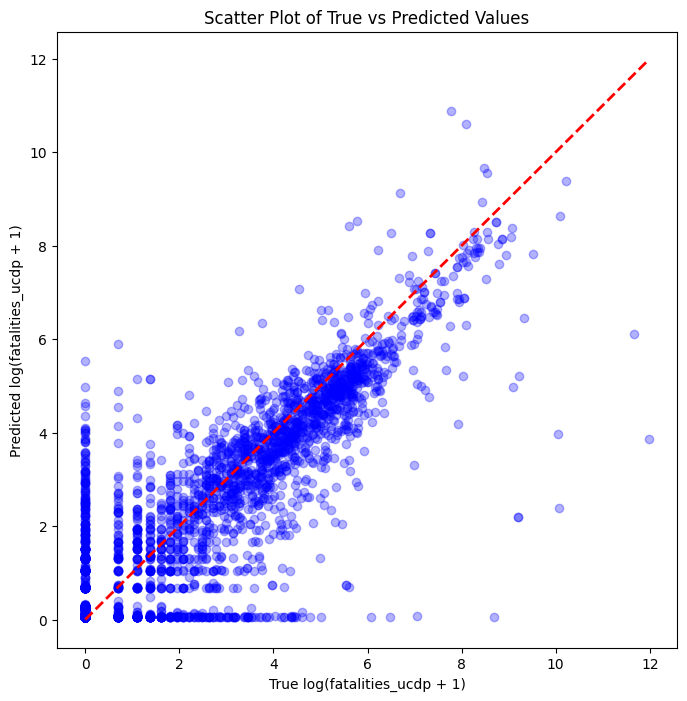

In [ ]:
df = pd.read_stata(file_path)
df['log_fatalities'] = np.log(df['fatalities_ucdp'] + 1)

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'period' is a column with year-month as integer (e.g., 201001 for Jan 2010)
# Leaving one topic out for OLS 'stock_topic_0',
predictors = [
    'stock_tokens',
    'log_fatalities'
]

# Sort data by time (assuming period is of the form YYYYMM)
df = df.sort_values(by=['id', 'period'])

# Shift 'log(fatalities_ucdp + 1)' by one period within each country to predict next month's log fatalities
df['log_fatalities_next'] = df.groupby('id')['log_fatalities'].shift(-1)


# Drop rows where 'log_fatalities_next' is NaN (occurs for the last period in each country)
df = df.dropna(subset=['log_fatalities_next'])

# Initialize lists to collect out-of-sample predictions and true labels
oos_predictions = []
oos_true_labels = []

# Get unique periods
all_periods = sorted(df['period'].unique())

for i, period in enumerate(all_periods):

    if period < 202001:
        continue

    # Only print coefficients for January periods
    if period % 100 == 1:  # If the month is January (e.g., 202001, 202101, etc.)
        print(f"Period: {period}")

    # Expanding window: Train on all data up to the current period, test on the next period
    train_df = df[df['period'] < period]
    test_df = df[df['period'] == period]

    if train_df.empty or test_df.empty:
        continue

    # Add a constant (intercept) to the model
    X_train = sm.add_constant(train_df[predictors])
    X_test = sm.add_constant(test_df[predictors])

    # Fit the OLS model
    ols = sm.OLS(train_df['log_fatalities_next'], X_train).fit()

    # Print the coefficients if it's January
    if period % 100 == 1:
        print(ols.params)

    # Make predictions on the test set
    test_pred = ols.predict(X_test)

    # Collect the out-of-sample predictions and true labels
    oos_predictions.extend(test_pred)
    oos_true_labels.extend(test_df['log_fatalities_next'])

# Convert lists to numpy arrays for easy processing
oos_predictions = np.array(oos_predictions)
oos_true_labels = np.array(oos_true_labels)

# Step 5: Evaluate the model using MSE and scatter plot
mse = mean_squared_error(oos_true_labels, oos_predictions)
print(f"Mean Squared Error: {mse:.4f}")

# Scatter plot of true vs predicted values
plt.figure(figsize=(8, 8))  # Square figure
plt.scatter(oos_true_labels, oos_predictions, alpha=0.3, color='blue')
plt.plot([oos_true_labels.min(), oos_true_labels.max()],
         [oos_true_labels.min(), oos_true_labels.max()],
         color='red', linestyle='--', linewidth=2)
plt.xlabel('True log(fatalities_ucdp + 1)')
plt.ylabel('Predicted log(fatalities_ucdp + 1)')
plt.title('Scatter Plot of True vs Predicted Values')
plt.show()

# Forecasting and Evaluating Conflict Violence with OLS and Performance Curves

This code performs an out-of-sample forecasting analysis using Ordinary Least Squares (OLS) regression to predict the likelihood of conflict violence in the next period, distinguishing between violence and non-violence scenarios. The results are then evaluated using ROC and Precision-Recall curves to understand the model's performance in different contexts. Let's break down the key steps and concepts involved in this analysis.

## 1. **Data Preparation and Feature Engineering**

The dataset, loaded from a `.dta` file, contains information about conflict violence across different countries and periods. The data preparation involves several steps:

- **Sorting and Lagging**: The data is first sorted by `id` (country identifier) and `period` (formatted as YYYYMM) to ensure chronological order. A new column, `anyviolence_next`, is created by shifting the `anyviolence` values by one period within each country. This lagging allows us to use current period data to predict whether there will be any violence in the next period:

$$
\text{anyviolence_next}_{t} = \text{anyviolence}_{t+1}
$$

- **Handling Missing Values**: Rows where `anyviolence_next` is missing (typically the last period for each country) are dropped, as these do not have a subsequent period to predict.

## 2. **OLS Regression with Expanding Window**

The code uses an expanding window approach to perform OLS regression. This technique involves incrementally increasing the training set size as more data becomes available over time, allowing the model to leverage more information for forecasting:

1. **Loop Through Periods**: The code iterates over each unique period in the dataset. For each period after 2020 (to ensure enough data for training), the following steps are performed:

2. **Expanding Window Strategy**:
   - **Training Set**: Data up to the current period.
   - **Test Set**: Data for the current period. This approach simulates a real-time forecasting scenario where we train the model on all past data and predict the next period's outcome.

3. **Model Training**:
   - The OLS model is trained using various predictors, including `stock_tokens` and multiple `stock_topic_*` variables, which represent different dimensions of topic modeling or stock attributes relevant to the study.
   - A constant (intercept term) is added to both the training and test datasets to account for the baseline level of violence that does not depend on the predictors.

### Mathematical Formulation of OLS:

The regression model used here can be expressed as:

$$
\text{anyviolence_next}_{i, t} = \beta_0 + \sum_{k=1}^{K} \beta_k \times \text{predictor}_{i, t, k} + \epsilon_{i, t}
$$

where:
- $ \beta_0 $ is the intercept.
- $ \beta_k $ are the coefficients for each predictor.
- $ \epsilon_{i, t} $ is the error term.

4. **Out-of-Sample Predictions**:
   - Predictions are made for the test set, and results are stored separately for cases where there was violence (`anyviolence` ≥ 0) and no violence (`anyviolence` = 0) in the previous period. This separation allows for differentiated evaluation of the model's performance in contexts of violence vs. non-violence.

## 3. **Model Evaluation: ROC and Precision-Recall Curves**

### **ROC Curve Analysis**

The **Receiver Operating Characteristic (ROC) curve** is used to assess the model's ability to distinguish between periods with and without violence:

- **False Positive Rate (FPR)**: Proportion of non-violent periods incorrectly classified as violent.
  
$$
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

- **True Positive Rate (TPR)**: Proportion of violent periods correctly classified as violent (sensitivity).

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

- **AUC (Area Under the Curve)**: A single scalar value that summarizes the overall ability of the model to discriminate between violence and non-violence. An AUC of 0.5 indicates no discriminative ability (random guessing), while an AUC of 1 indicates perfect discrimination.

The ROC curves are plotted separately for periods with violence and without violence, showing how well the model distinguishes between the two scenarios.

### **Precision-Recall Curve Analysis**

The **Precision-Recall Curve** provides another perspective on model performance, particularly useful when dealing with imbalanced datasets where one class (e.g., non-violence) is more frequent than the other:

- **Precision**: Proportion of predicted violent periods that are actually violent.

$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

- **Recall (Sensitivity)**: Proportion of actual violent periods that are correctly predicted.

$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

The curves are plotted separately for both cases (violence and no violence), providing insights into how precision and recall trade off against each other. High precision with low recall indicates that the model is conservative in predicting violence (few false positives), while high recall with low precision suggests the model captures most violent periods but at the cost of more false positives.



Period: 202001
const            -6.944080e-02
stock_tokens      8.433658e-07
stock_topic_1    -4.209127e-01
stock_topic_2     4.110991e+00
stock_topic_3    -3.050914e-01
stock_topic_4    -7.219018e-01
stock_topic_5     3.828372e-01
stock_topic_6     7.307837e-01
stock_topic_7     2.427788e-01
stock_topic_8    -2.693155e-01
stock_topic_9    -1.148418e+00
stock_topic_10   -2.028787e-01
stock_topic_11    7.664826e-01
stock_topic_12   -2.498225e-01
stock_topic_13   -7.401691e-02
stock_topic_14    8.243503e-02
dtype: float64
Period: 202101
const            -7.531675e-02
stock_tokens      8.667686e-07
stock_topic_1    -1.786799e-01
stock_topic_2     4.084707e+00
stock_topic_3    -2.915720e-01
stock_topic_4    -6.608902e-01
stock_topic_5     2.622894e-01
stock_topic_6     6.477997e-01
stock_topic_7     2.831806e-01
stock_topic_8    -2.535675e-01
stock_topic_9    -1.213692e+00
stock_topic_10   -1.744328e-01
stock_topic_11    7.893844e-01
stock_topic_12   -2.451826e-01
stock_topic_13   -7.05363

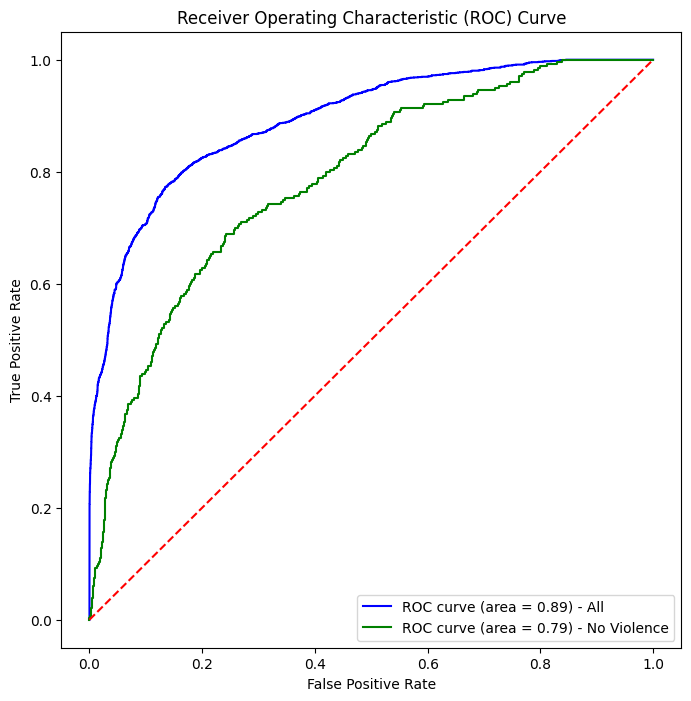

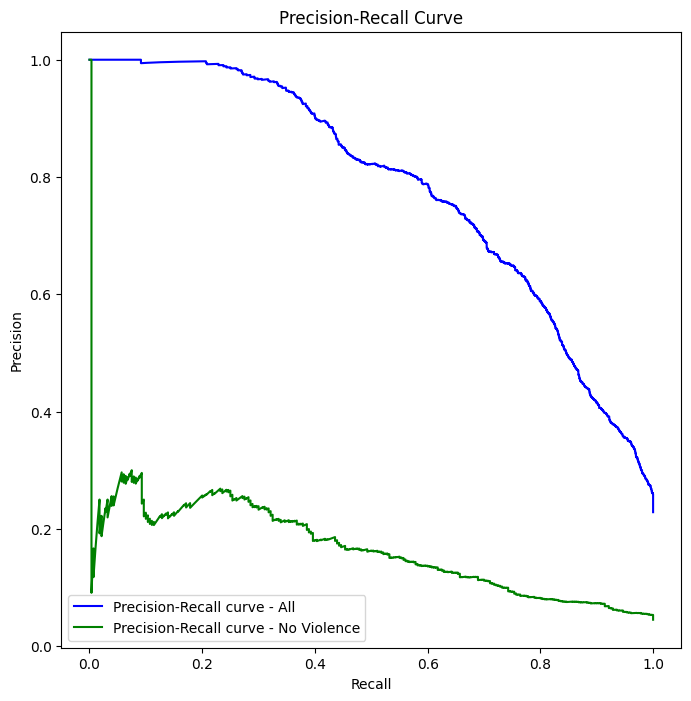

In [ ]:
df = pd.read_stata(file_path)
# Assuming df is your DataFrame and 'period' is a column with year-month as integer (e.g., 201001 for Jan 2010)
# Leaving one topic out for OLS 'stock_topic_0',
predictors = [
    'stock_tokens', 'stock_topic_1', 'stock_topic_2',
    'stock_topic_3', 'stock_topic_4', 'stock_topic_5', 'stock_topic_6',
    'stock_topic_7', 'stock_topic_8', 'stock_topic_9', 'stock_topic_10',
    'stock_topic_11', 'stock_topic_12', 'stock_topic_13', 'stock_topic_14'
]

# Sort data by time (assuming period is of the form YYYYMM)
df = df.sort_values(by=['id', 'period'])

# Shift 'anyviolence' by one period within each country to predict next month's violence
df['anyviolence_next'] = df.groupby('id')['anyviolence'].shift(-1)

# Drop rows where 'anyviolence_next' is NaN (occurs for the last period in each country)
df = df.dropna(subset=['anyviolence_next'])

# Initialize lists to collect out-of-sample predictions and true labels
oos_predictions_violence = []
oos_true_labels_violence = []
oos_predictions_no_violence = []
oos_true_labels_no_violence = []

# Get unique periods
all_periods = sorted(df['period'].unique())

for i, period in enumerate(all_periods):

    if period < 202001:
        continue

    # Only print coefficients for January periods
    if period % 100 == 1:  # If the month is January (e.g., 202001, 202101, etc.)
        print(f"Period: {period}")

    # Expanding window: Train on all data up to the current period, test on the next period
    train_df = df[df['period'] < period]
    test_df = df[df['period'] == period]

    if train_df.empty or test_df.empty:
        continue

    # Add a constant (intercept) to the model
    X_train = sm.add_constant(train_df[predictors])
    X_test = sm.add_constant(test_df[predictors])

    # Fit the OLS model
    ols = sm.OLS(train_df['anyviolence_next'], X_train).fit()

    # Print the coefficients if it's January
    if period % 100 == 1:
        print(ols.params)

    # Make predictions on the test set
    test_pred = ols.predict(X_test)

    # Collect the out-of-sample predictions and true labels for violence cases
    oos_predictions_violence.extend(test_pred[test_df['anyviolence'] >= 0])
    oos_true_labels_violence.extend(test_df['anyviolence_next'][test_df['anyviolence'] >= 0])

    # Collect the out-of-sample predictions and true labels for non-violence cases
    oos_predictions_no_violence.extend(test_pred[test_df['anyviolence'] == 0])
    oos_true_labels_no_violence.extend(test_df['anyviolence_next'][test_df['anyviolence'] == 0])

# Convert lists to numpy arrays for easy processing
oos_predictions_violence = np.array(oos_predictions_violence)
oos_true_labels_violence = np.array(oos_true_labels_violence)
oos_predictions_no_violence = np.array(oos_predictions_no_violence)
oos_true_labels_no_violence = np.array(oos_true_labels_no_violence)

# Step 5: Evaluate the model using ROC and Precision-Recall curves

# ROC Curve for both cases
fpr_violence, tpr_violence, _ = roc_curve(oos_true_labels_violence, oos_predictions_violence)
roc_auc_violence = roc_auc_score(oos_true_labels_violence, oos_predictions_violence)

fpr_no_violence, tpr_no_violence, _ = roc_curve(oos_true_labels_no_violence, oos_predictions_no_violence)
roc_auc_no_violence = roc_auc_score(oos_true_labels_no_violence, oos_predictions_no_violence)

plt.figure(figsize=(8, 8))  # Square figure
plt.plot(fpr_violence, tpr_violence, color='blue', label=f'ROC curve (area = {roc_auc_violence:.2f}) - All')
plt.plot(fpr_no_violence, tpr_no_violence, color='green', label=f'ROC curve (area = {roc_auc_no_violence:.2f}) - No Violence')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve for both cases
precision_violence, recall_violence, _ = precision_recall_curve(oos_true_labels_violence, oos_predictions_violence)

precision_no_violence, recall_no_violence, _ = precision_recall_curve(oos_true_labels_no_violence, oos_predictions_no_violence)

plt.figure(figsize=(8, 8))  # Square figure
plt.plot(recall_violence, precision_violence, color='blue', label='Precision-Recall curve - All')
plt.plot(recall_no_violence, precision_no_violence, color='green', label='Precision-Recall curve - No Violence')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


# Forecasting Future Conflict Dynamics Using OLS Regression

This code snippet aims to predict future conflict-related outcomes, specifically the logarithm of conflict fatalities and the occurrence of any violence in the upcoming period (June 2024). The analysis leverages historical data and employs Ordinary Least Squares (OLS) regression models for forecasting. The approach involves several key steps, including data preparation, feature selection, model training, and prediction. Let's explore each component in detail.

## 1. **Data Preparation and Feature Engineering**

The dataset is loaded from a `.dta` file (a format typically used in econometrics and statistics). After loading the data into a DataFrame (`df`), several transformations are performed:

- **Log Transformation of Fatalities**: The `log_fatalities` variable is computed as the natural logarithm of the conflict fatalities (`fatalities_ucdp`) plus one:

$$
\text{log_fatalities} = \log(\text{fatalities_ucdp} + 1)
$$

This transformation is applied to handle skewness in the data, as conflict fatalities can range from 0 to very large numbers. Adding 1 before taking the logarithm ensures that zero fatalities are included without causing mathematical errors (since \(\log(0)\) is undefined).

- **Sorting and Lagging**: The data is sorted by `id` (country identifier) and `period` (formatted as YYYYMM) to ensure it is in chronological order for each country. Two new lagged variables are created:
  - `log_fatalities_next`: Represents the log-transformed fatalities for the next period.
  - `anyviolence_next`: Indicates whether there will be any violence in the next period.

These lagged variables allow the model to predict future values based on past data.

## 2. **Selection of Predictors and Training Data**

The predictors used in the model include various topic-related and token-related variables (`stock_tokens`, `stock_topic_1`, ..., `stock_topic_14`). These variables represent different dimensions of stock market and topic modeling data that might correlate with conflict outcomes.

- **Filtering for Prediction and Training**:
  - **Prediction Data (`prediction_df`)**: This subset includes rows where the prediction needs to be made (specifically for June 2024, `period = 202406`). It filters out rows where the target variables (`log_fatalities_next` and `anyviolence_next`) are missing, as these represent the future values we aim to predict.
  - **Training Data (`train_df`)**: This subset includes all available data before June 2024 that has no missing values in the target variables, ensuring that the OLS model is trained on complete cases.

## 3. **Model Building and Fitting**

Two separate OLS regression models are built to forecast each target variable:

- **OLS for Log Fatalities**:
  - **Model Specification**: The OLS model is specified to predict `log_fatalities_next` using the chosen predictors. An intercept term (constant) is added to the model to capture the baseline level of conflict fatalities.
  
  - **Fitting the Model**: The model is trained on the `train_df` dataset. The fitted model estimates coefficients ($\beta$) that minimize the sum of squared errors between the observed and predicted values of `log_fatalities_next`.

$$
\text{log_fatalities_next}_{i, t} = \beta_0 + \sum_{k=1}^{K} \beta_k \cdot \text{predictor}_{i, t, k} + \epsilon_{i, t}
$$

where:
- $ \beta_0 $ is the intercept.
- $ \beta_k $ are the coefficients for each predictor.
- $ \epsilon_{i, t} $ is the error term.

- **OLS for Any Violence**:
  - Similar to the fatalities model, another OLS model is trained to predict `anyviolence_next`, a binary variable indicating whether any violence will occur in the next period. The predictors and model setup are identical to those used for `log_fatalities_next`.

$$
\text{anyviolence_next}_{i, t} = \alpha_0 + \sum_{k=1}^{K} \alpha_k \cdot \text{predictor}_{i, t, k} + \zeta_{i, t}
$$

where:
- $ \alpha_0 $ is the intercept.
- $ \alpha_k $ are the coefficients for each predictor.
- $ \zeta_{i, t} $ is the error term.

## 4. **Making Predictions**

- **Predictions for June 2024**:
  - Using the fitted models, predictions are made on the test set (`prediction_df`). The model predicts `pred_log_fatalities` for the number of log fatalities and `pred_anyviolence` for the likelihood of any violence in the upcoming period (June 2024).
  
  - **Thresholding for Binary Prediction**: Although the code mentions thresholding for `anyviolence` (to convert continuous predictions to binary outcomes), this step is commented out. To convert the predictions into a binary form (violence vs. no violence), a threshold (e.g., 0.5) can be applied:

$$
\text{pred_anyviolence_binary} =
\begin{cases}
1 & \text{if } \text{pred_anyviolence} > 0.5 \\
0 & \text{otherwise}
\end{cases}
$$

## 5. **Combining and Saving Predictions**

The predictions are combined into a new DataFrame, `predictions_df`, which includes the country identifier (`id`), predicted log fatalities (`pred_log_fatalities`), and predicted probability of any violence (`pred_anyviolence`). This DataFrame is then ready for further analysis or export.

- **Optional Saving**: The predictions can be saved to a CSV file for external use or further reporting, although this step is commented out in the provided code.


In [ ]:
df = pd.read_stata(file_path)

df['log_fatalities'] = np.log(df['fatalities_ucdp'] + 1)
# Assuming df is your DataFrame and 'period' is a column with year-month as integer (e.g., 201001 for Jan 2010)
# Leaving one topic out for OLS 'stock_topic_0',


# Assuming df is your DataFrame and 'period' is a column with year-month as integer (e.g., 201001 for Jan 2010)
# Leaving one topic out for OLS 'stock_topic_0',
predictors = [
    'stock_tokens', 'stock_topic_1', 'stock_topic_2',
    'stock_topic_3', 'stock_topic_4', 'stock_topic_5', 'stock_topic_6',
    'stock_topic_7', 'stock_topic_8', 'stock_topic_9', 'stock_topic_10',
    'stock_topic_11', 'stock_topic_12', 'stock_topic_13', 'stock_topic_14'
]

# Sort data by time (assuming period is of the form YYYYMM)
df = df.sort_values(by=['id', 'period'])

# Shift 'log(fatalities_ucdp + 1)' and 'anyviolence' by one period within each country to predict next month's values
df['log_fatalities_next'] = df.groupby('id')['log_fatalities'].shift(-1)
df['anyviolence_next'] = df.groupby('id')['anyviolence'].shift(-1)

# Identify the rows that need to be predicted (those with NaN in the target variables)
prediction_df = df[(df['period'] == 202406) & (df['log_fatalities_next'].isna()) & (df['anyviolence_next'].isna())]

# Select the training data (all periods before 202407 without NaN in target variables)
train_df = df[(df['period'] < 202406) & df['log_fatalities_next'].notna() & df['anyviolence_next'].notna()]

# Ensure the data for prediction (the period 202407) is not empty
if prediction_df.empty:
    raise ValueError("No data available for prediction in the period 202407.")

# Add a constant (intercept) to the model
X_train = sm.add_constant(train_df[predictors])
X_test = sm.add_constant(prediction_df[predictors])

# Fit the OLS model to predict log_fatalities
ols_fatalities = sm.OLS(train_df['log_fatalities_next'], X_train).fit()
pred_log_fatalities = ols_fatalities.predict(X_test)

# Fit the OLS model to predict anyviolence
ols_anyviolence = sm.OLS(train_df['anyviolence_next'], X_train).fit()
pred_anyviolence = ols_anyviolence.predict(X_test)

# Since `anyviolence` is binary, we should threshold the predictions
#pred_anyviolence = (pred_anyviolence > 0.5).astype(int)

# Combine predictions into a DataFrame
predictions_df = pd.DataFrame({
    'id': prediction_df['id'],
    'pred_log_fatalities': pred_log_fatalities,
    'pred_anyviolence': pred_anyviolence
})


# Save the predictions to a CSV file
#output_file = '/mnt/data/predictions_202407.csv'
#predictions_df.to_csv(output_file, index=False)

#print(f"Predictions saved to {output_file}")

predictions_df

,id,pred_log_fatalities,pred_anyviolence
173,1.0,-0.329301,0.028419
347,2.0,-0.004844,0.060793
521,3.0,-0.837314,-0.069017
695,4.0,1.708733,0.341617
869,5.0,1.279424,0.325962
...,...,...,...
29735,171.0,2.065128,0.553236
29909,172.0,1.375009,0.311042
30083,173.0,2.230855,0.540034
30257,174.0,3.773876,0.863777
